In [1]:
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

from keras.datasets import cifar10

from kerasutils import hits_and_misses, describe_model, plot_training_data
from imageutils import block_dct
from imageutils import dataset_transform_block_dct

import matplotlib.pyplot as plt
import numpy as np

import random

/home/ubuntu/.virtualenvs/gpu2/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(trainX_orig, trainY_orig), (testX_orig, testY_orig) = cifar10.load_data()

In [3]:
cifar10_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                 'dog', 'frog', 'horse', 'ship', 'truck']
print(cifar10_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# Have to decimate training set size due to memory constraints?
# (trainX, testX_dummy, trainY, testY_dummy) = train_test_split(trainX_orig, trainY_orig, test_size=0.25)

In [5]:
trainX = trainX_orig
trainY = trainY_orig
testX = testX_orig
testY = testY_orig

In [6]:
trainX = trainX / 255.0
testX = testX / 255.0
print(trainX.shape)
print(testX.shape)
print(trainX.dtype)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
float64


In [7]:
trainX = dataset_transform_block_dct(trainX,8,4)
testX = dataset_transform_block_dct(testX,8,4)
print(trainX.shape)
print(testX.shape)

(50000, 56, 56, 3)
(10000, 56, 56, 3)


In [8]:
# Transform labels from int to one-hot vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

print(trainY.shape)
print(testY.shape)
n_classes = trainY.shape[1]
height = trainX.shape[1]
width = trainX.shape[2]
channels = trainX.shape[3]

print(height, width, channels)

(50000, 10)
(10000, 10)
56 56 3


In [9]:
# "Transform" CNN architecture with Keras
#regularizer = regularizers.l2(1e-5)
# 73% first shot
# 76% second pass
regularizer=None
model = Sequential()
model.add(Conv2D(input_shape=(height,width,channels), filters=128,  
                 use_bias=False, kernel_size=(5,5), strides=8,
                 kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=128,use_bias=True, kernel_size=(3,3),
                 kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Conv2D(filters=512,use_bias=True, kernel_size=(3,3),
                 strides=2,
                 kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
#model.add(BatchNormalization())
model.add(Dense(512, kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#model.add(Dense(128, kernel_regularizer=regularizer))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(lb.classes_.shape[0], activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [148]:
# "Transform" CNN architecture with Keras
regularizer = regularizers.l2(0.003)

model = Sequential()
model.add(Conv2D(input_shape=(height,width,channels), filters=64,  
                 use_bias=True, kernel_size=(8,8), strides=8,
                 kernel_regularizer=regularizer))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.1))
#model.add(Conv2D(filters=192,use_bias=True, kernel_size=(3,3)))
#model.add(Activation('relu'))
#model.add(Dropout(0.4))
model.add(Conv2D(filters=192,use_bias=True, kernel_size=(3,3),
                 kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(Dropout(0.3))
#model.add(Dense(128))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(128))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(lb.classes_.shape[0], activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
# Deeper architecture
# https://arxiv.org/pdf/1412.6806.pdf
model = Sequential()
model.add(Conv2D(input_shape=(height,width,channels), filters=64,  
                 use_bias=True, kernel_size=(8,8), strides=8))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv2D(filters=192, kernel_size=(3,3), strides=2))
#model.add(Conv2D(filters=192, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
n_epochs = 20
batch_size = 512
H = model.fit(trainX, trainY, validation_data=(testX, testY), 
              epochs=n_epochs, batch_size=batch_size)
print('Done!!!')

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 8s 169us/step - loss: 0.6899 - acc: 0.7536 - val_loss: 0.6850 - val_acc: 0.7588
Epoch 2/20
50000/50000 [==============================] - 8s 164us/step - loss: 0.6858 - acc: 0.7566 - val_loss: 0.6964 - val_acc: 0.7572
Epoch 3/20
50000/50000 [==============================] - 8s 167us/step - loss: 0.6887 - acc: 0.7558 - val_loss: 0.6818 - val_acc: 0.7624
Epoch 4/20
50000/50000 [==============================] - 9s 172us/step - loss: 0.6876 - acc: 0.7560 - val_loss: 0.6843 - val_acc: 0.7615
Epoch 5/20
50000/50000 [==============================] - 8s 168us/step - loss: 0.6825 - acc: 0.7571 - val_loss: 0.6835 - val_acc: 0.7625
Epoch 6/20
50000/50000 [==============================] - 9s 170us/step - loss: 0.6846 - acc: 0.7574 - val_loss: 0.6789 - val_acc: 0.7637
Epoch 7/20
50000/50000 [==============================] - 9s 174us/step - loss: 0.6752 - acc: 0.7611 - val_loss: 0.6744 - 

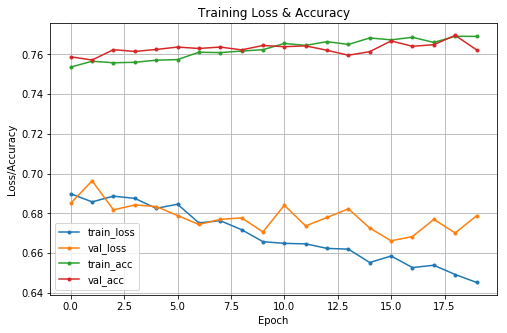

In [13]:
plot_training_data(H)

In [14]:
# Evaluate TEST model class prediction accuracy
print("[INFO] Evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
target_names = [str(x) for x in lb.classes_]
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=cifar10_names))


[INFO] Evaluating network...
             precision    recall  f1-score   support

   airplane       0.84      0.75      0.79      1000
 automobile       0.84      0.88      0.86      1000
       bird       0.79      0.60      0.68      1000
        cat       0.62      0.53      0.57      1000
       deer       0.71      0.76      0.73      1000
        dog       0.63      0.67      0.65      1000
       frog       0.78      0.88      0.83      1000
      horse       0.81      0.80      0.81      1000
       ship       0.82      0.89      0.85      1000
      truck       0.77      0.86      0.81      1000

avg / total       0.76      0.76      0.76     10000



In [15]:
# Evaluate TRAIN model class prediction accuracy
print("[INFO] Evaluating network...")
trainPreds = model.predict(trainX, batch_size=batch_size)
target_names = [str(x) for x in lb.classes_]
print(classification_report(trainY.argmax(axis=1),
                            trainPreds.argmax(axis=1),
                            target_names=cifar10_names))

[INFO] Evaluating network...
             precision    recall  f1-score   support

   airplane       0.95      0.92      0.93      5000
 automobile       0.96      0.97      0.96      5000
       bird       0.95      0.83      0.89      5000
        cat       0.86      0.79      0.82      5000
       deer       0.87      0.93      0.90      5000
        dog       0.83      0.85      0.84      5000
       frog       0.92      0.96      0.94      5000
      horse       0.94      0.94      0.94      5000
       ship       0.94      0.98      0.96      5000
      truck       0.93      0.97      0.95      5000

avg / total       0.91      0.91      0.91     50000



In [16]:
describe_model(model)

Layer 0: <class 'keras.layers.convolutional.Conv2D'>
    input=(None, 56, 56, 3)
    output=(None, 7, 7, 128)
    act=<function linear at 0x7f844e78e1e0>
    strides=(8, 8)
Layer 1: <class 'keras.layers.core.Activation'>
    input=(None, 7, 7, 128)
    output=(None, 7, 7, 128)
    act=<function relu at 0x7f844e800f28>
Layer 2: <class 'keras.layers.core.Dropout'>
    input=(None, 7, 7, 128)
    output=(None, 7, 7, 128)
    rate=0.5
Layer 3: <class 'keras.layers.convolutional.Conv2D'>
    input=(None, 7, 7, 128)
    output=(None, 5, 5, 128)
    act=<function linear at 0x7f844e78e1e0>
    strides=(1, 1)
Layer 4: <class 'keras.layers.core.Activation'>
    input=(None, 5, 5, 128)
    output=(None, 5, 5, 128)
    act=<function relu at 0x7f844e800f28>
Layer 5: <class 'keras.layers.core.Dropout'>
    input=(None, 5, 5, 128)
    output=(None, 5, 5, 128)
    rate=0.5
Layer 6: <class 'keras.layers.convolutional.Conv2D'>
    input=(None, 5, 5, 128)
    output=(None, 2, 2, 512)
    act=<function li

In [47]:
layer = model.layers[2]
layer.rate = 0.1

print(layer.rate)
print(layer.get_config())

0.1
{'seed': None, 'noise_shape': None, 'rate': 0.1, 'trainable': True, 'name': 'dropout_1'}


In [ ]:
class DctGenerator:
    def __init__(noise=0.1):
        self.noise=noise
    
    def flow()

In [10]:
n_epochs = 50
batch_size = 256

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zoom_range=0.2,     # zoom image
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(trainX)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(trainX, trainY,
                                 batch_size=batch_size),
                                 epochs=n_epochs,
                                 validation_data=(testX, testY))

print('Done!!!')

Using real-time data augmentation.
Epoch 1/50
147/147 [==============================] - 34s 230ms/step - loss: 3.7534 - acc: 0.2168 - val_loss: 2.9024 - val_acc: 0.2100
Epoch 2/50
147/147 [==============================] - 33s 225ms/step - loss: 2.2238 - acc: 0.2984 - val_loss: 2.0284 - val_acc: 0.3332
Epoch 3/50
147/147 [==============================] - 33s 224ms/step - loss: 2.0065 - acc: 0.3317 - val_loss: 2.0958 - val_acc: 0.2972
Epoch 4/50
147/147 [==============================] - 33s 224ms/step - loss: 1.9196 - acc: 0.3587 - val_loss: 1.8495 - val_acc: 0.3853
Epoch 5/50
147/147 [==============================] - 33s 223ms/step - loss: 1.8824 - acc: 0.3745 - val_loss: 1.9753 - val_acc: 0.3476
Epoch 6/50
147/147 [==============================] - 33s 224ms/step - loss: 1.8340 - acc: 0.3909 - val_loss: 1.8587 - val_acc: 0.3810
Epoch 7/50
147/147 [==============================] - 33s 223ms/step - loss: 1.8080 - acc: 0.3991 - val_loss: 1.7701 - val_acc: 0.4195
Epoch 8/50
147/147 [

KeyboardInterrupt: 

In [17]:
preds = predictions.argmax(axis=1)
targets = testY.argmax(axis=1)
hits, misses = hits_and_misses(preds, targets)
print('{0} hits, {1} misses ({2}%)'.format(len(hits), len(misses), len(hits)/float(len(predictions))))

7623 hits, 2377 misses (0.7623%)


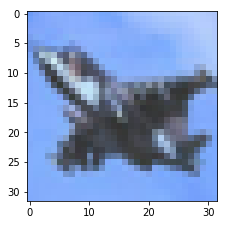

Target: airplane, Predicted: airplane


In [88]:
# Look at examples of hits
idx = hits[random.randint(0,len(hits))]
im = testX_orig[idx]
plt.figure(figsize=(3.5,3.5))
plt.imshow(im)
plt.show()
print('Target: {0}, Predicted: {1}'.format(cifar10_names[targets[idx]], cifar10_names[preds[idx]]))

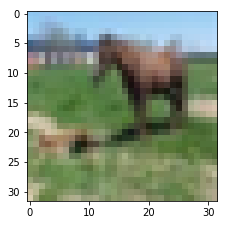

Target: horse, Predicted: deer


In [95]:
# Look at examples of misses
idx = misses[random.randint(0,len(misses))]
im = testX_orig[idx]
plt.figure(figsize=(3.5,3.5))
plt.imshow(im)
plt.show()
print('Target: {0}, Predicted: {1}'.format(cifar10_names[targets[idx]], cifar10_names[preds[idx]]))
